In [ ]:
# import os

# dir='/content/'

# for root, dirs, files in os.walk(dir):
#   for name in files:
#     if not name.endswith(("Differenced.csv", "Metrics_exo_arima.csv")):
#       os.remove(os.path.join(root, name))

# Importing All Required Libraries

In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Loading the data and visualizing

## Loading

In [ ]:
# Load data from CSV file
df = pd.read_csv('USDifferenced.csv', parse_dates=['Date'], index_col='Date')
data = df

In [ ]:
data.head()

,TMP,REER,UR,M3,TULCM,CPI,TSP,PPI,TC,GDP
Date,,,,,,,,,,
1961-01-01,1.044624,98.430090,10.257387,1.725986,0.476618,0.025315,8.916816,0.000000,0.173986,-1.551812
1961-01-04,5.972159,99.091846,8.506342,1.844241,-0.667265,-0.004219,5.934066,-0.224243,0.243277,2.233583
1961-01-07,-0.760345,94.599362,7.927278,1.686672,-0.476618,0.049223,2.385892,0.051748,-0.094061,1.445466
1961-01-10,0.147424,96.804990,7.721480,1.760456,-0.190647,0.018283,1.773050,0.017249,0.112688,3.385609
1962-01-01,-2.136244,103.148840,8.383555,2.070000,0.381294,0.049223,-1.194624,0.103497,-0.013871,1.171746


In [ ]:
data.tail()

,TMP,REER,UR,M3,TULCM,CPI,TSP,PPI,TC,GDP
Date,,,,,,,,,,
2021-01-10,0.510852,107.797607,4.285992,2.509757,2.742727,2.455239,1.633706,3.158538,2.350733,0.761446
2022-01-01,-0.498891,108.842449,3.918929,1.742497,1.465331,2.610361,-1.646300,6.303243,7.678091,-2.033421
2022-01-04,-0.190572,113.114043,3.636741,-0.303082,0.281902,2.802331,-6.130385,9.742208,3.896592,-1.887636
2022-01-07,-0.995895,117.282351,3.601100,-0.199074,1.954705,1.670766,-4.775023,-1.495374,1.332981,0.146096
2022-01-10,-0.461691,117.934721,3.623522,-1.225234,1.494172,1.278108,0.101310,-1.569388,0.366584,-1.035848


## Visualizing

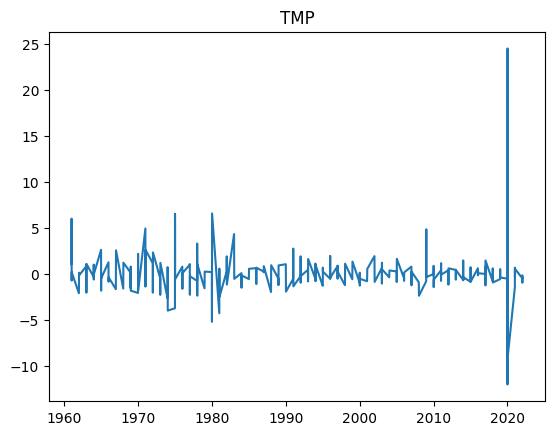

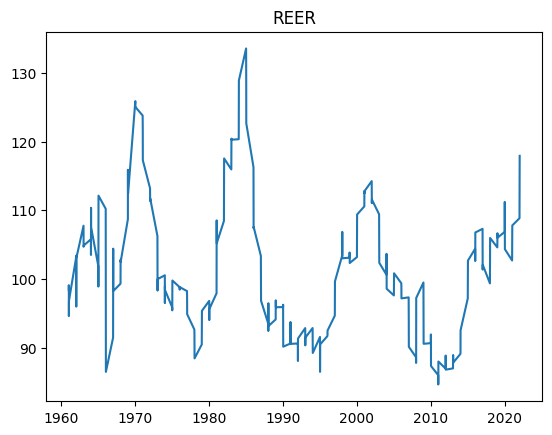

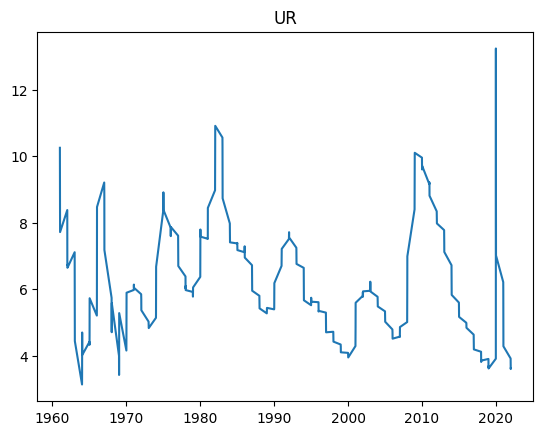

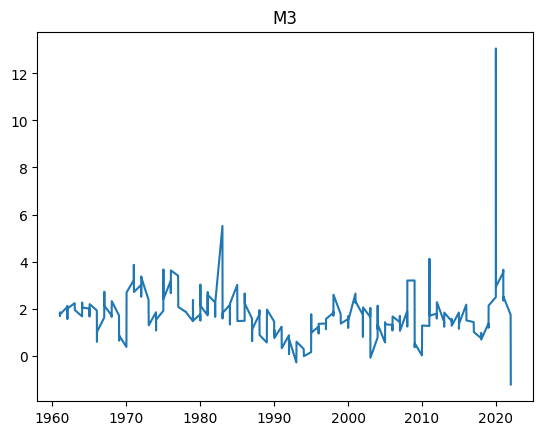

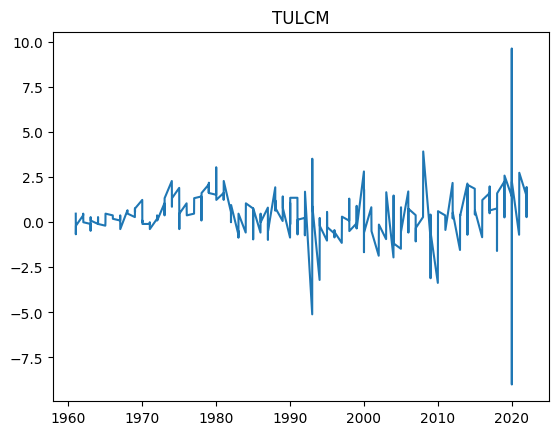

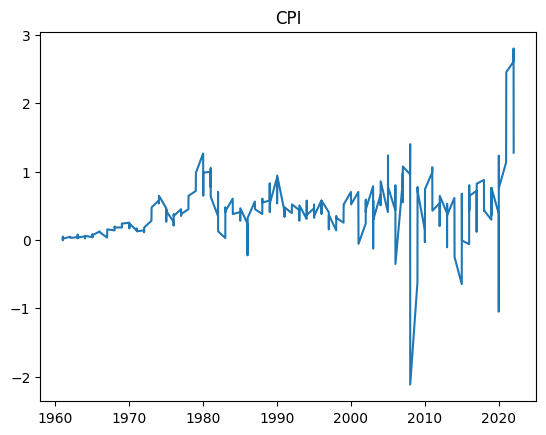

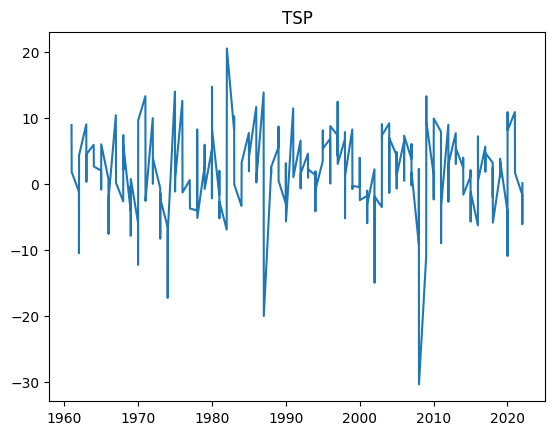

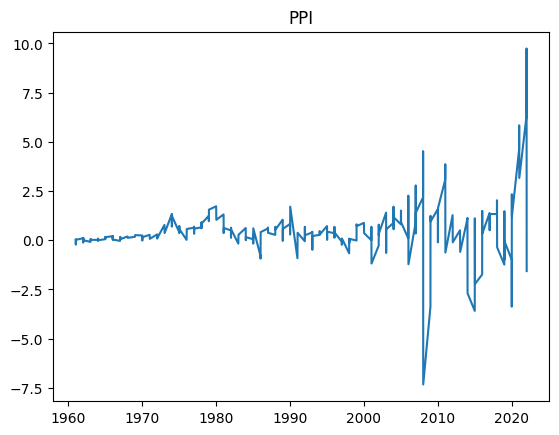

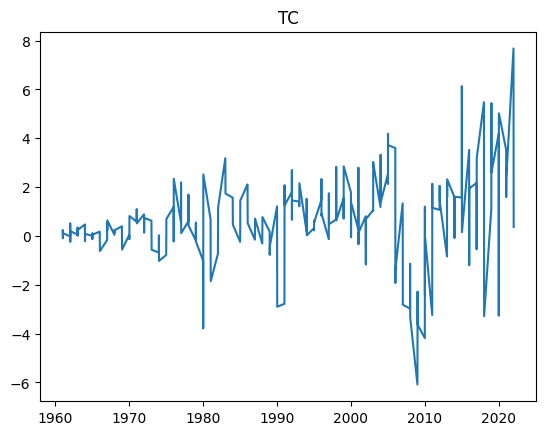

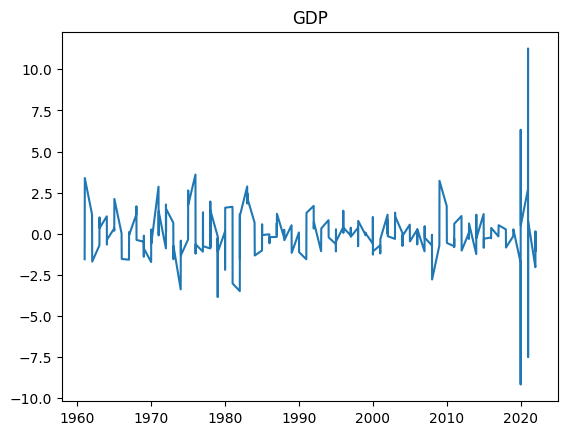

In [ ]:
for feature in data.columns:
    plt.figure()
    plt.plot(df[feature])
    plt.title(feature)

# Forecasting using LSTM

## Defining custom functions

In [ ]:
def split_timeseries(df, train_size = 0.7, valid_size = 0.15, test_size = 0.15):
    # Split data into train valid and test sets
    train_end = int(len(data) * train_size)
    valid_size = int(len(data) * valid_size)
    train, valid, test = df.iloc[:train_end], df.iloc[train_end:train_end+valid_size], df.iloc[train_end+valid_size:]
    return train, valid, test

train, valid, test = split_timeseries(df)
print(train.shape, valid.shape, test.shape)

(173, 10) (37, 10) (38, 10)


In [ ]:
# Function to create input/output sequences
def create_dataset(data, col, look_back):
  data = data[col]
  X, Y = [], []
  for i in range(len(data)-look_back):
      # print(i, data[i+look_back])
      X.append(data[i:i+look_back])
      Y.append(data[i+look_back])
  return np.array(X), np.array(Y)

In [ ]:
create_dataset(train, 'TMP', 4)

(array([[ 1.04462364,  5.97215898, -0.76034472,  0.14742397],
        [ 5.97215898, -0.76034472,  0.14742397, -2.13624365],
        [-0.76034472,  0.14742397, -2.13624365, -0.45390452],
        [ 0.14742397, -2.13624365, -0.45390452,  0.09616652],
        [-2.13624365, -0.45390452,  0.09616652, -0.18897975],
        [-0.45390452,  0.09616652, -0.18897975,  0.79343356],
        [ 0.09616652, -0.18897975,  0.79343356,  0.99849618],
        [-0.18897975,  0.79343356,  0.99849618, -2.07548603],
        [ 0.79343356,  0.99849618, -2.07548603,  1.05641666],
        [ 0.99849618, -2.07548603,  1.05641666, -0.35481106],
        [-2.07548603,  1.05641666, -0.35481106,  0.97779081],
        [ 1.05641666, -0.35481106,  0.97779081, -0.65071035],
        [-0.35481106,  0.97779081, -0.65071035, -0.05891034],
        [ 0.97779081, -0.65071035, -0.05891034,  2.58670565],
        [-0.65071035, -0.05891034,  2.58670565, -1.86203947],
        [-0.05891034,  2.58670565, -1.86203947, -0.02612151],
        

## Selecting best model architectures for each variable and visualization
This was done by hypertuning various hyperparameters many times

In [ ]:
lookback = 4
model_arch = {
    "TMP" : {
        "layers" : [LSTM(64, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(16), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },
    "REER" : {
        "layers" : [LSTM(64, input_shape=(lookback, 1), return_sequences=True), Dropout(0.2),LSTM(64), Dense(16), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },
    "UR" : {
        "layers" : [LSTM(64, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(16), Dense(1)],
        "optimizer": Adam(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },
    "M3" : {
        "layers" : [LSTM(64, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(16), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },
    "TULCM" : {
        "layers" : [LSTM(32, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(64), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },

    "CPI" : {
        "layers" : [LSTM(256, input_shape=(lookback, 1)), Dense(128), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },

    "TSP" : {
        "layers" : [LSTM(64, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(16), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },
    # "GDP" : {
    #     "layers" : [LSTM(128, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(16), Dense(1)],
    #     "optimizer": RMSprop(0.001),
    #     "scaler": StandardScaler(),
    #     "lookback": 4
    # },
    "TC" : {
        "layers" : [LSTM(32, input_shape=(lookback, 1)), Dense(64), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    },
}

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.5852903023415882 0.779957247041716 0.6939433014427601
Test:  22.527481353096046 0.09247229818358216 2.0458345060859604
FITTED MAPE: 1.6685737429923442, RMSE: 1.9699249660175837, MAE: 0.7504203355012952


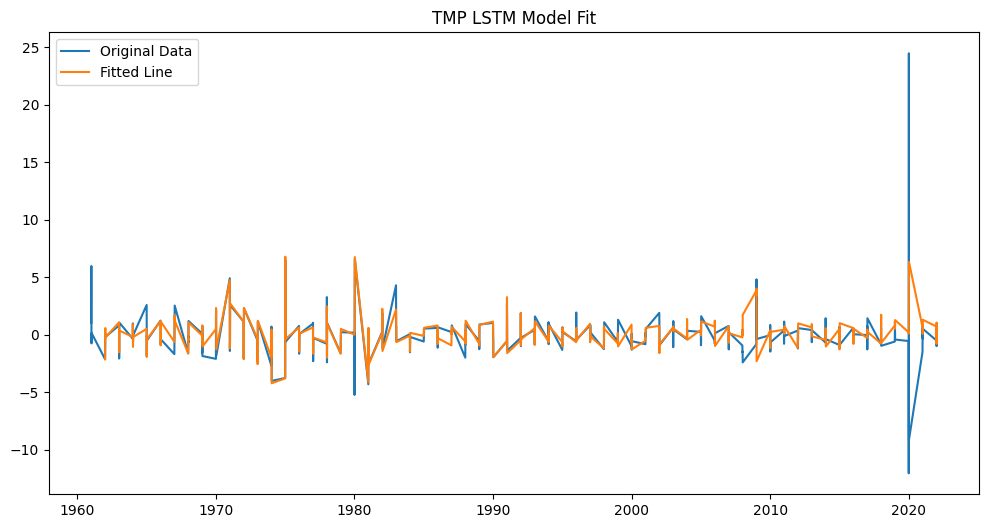

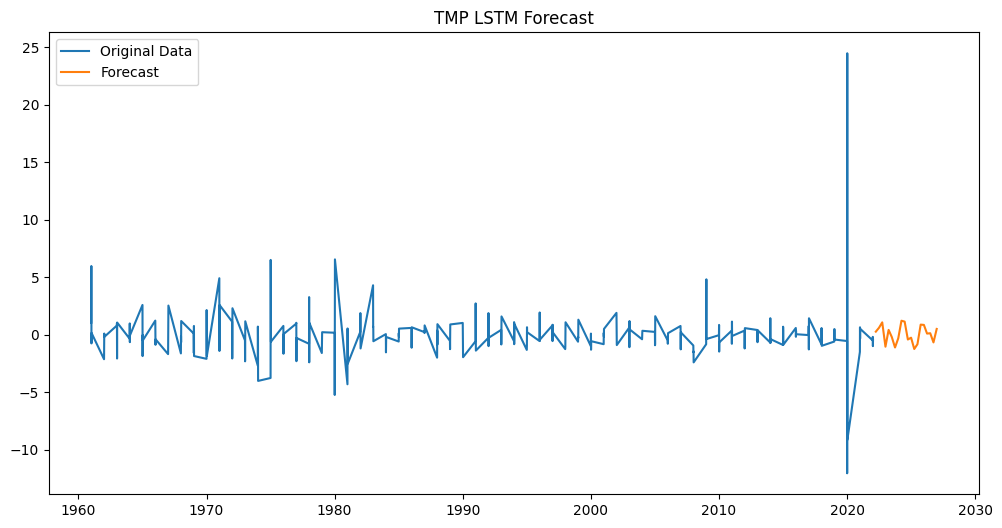

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  8.418904794384595 0.9244365665810732 0.020163654337803795
Test:  8.608663131961706 0.7237996921994766 0.02403320014664456
FITTED MAPE: 0.02010322883000956, RMSE: 2.7790756265974657, MAE: 2.0547920647689866


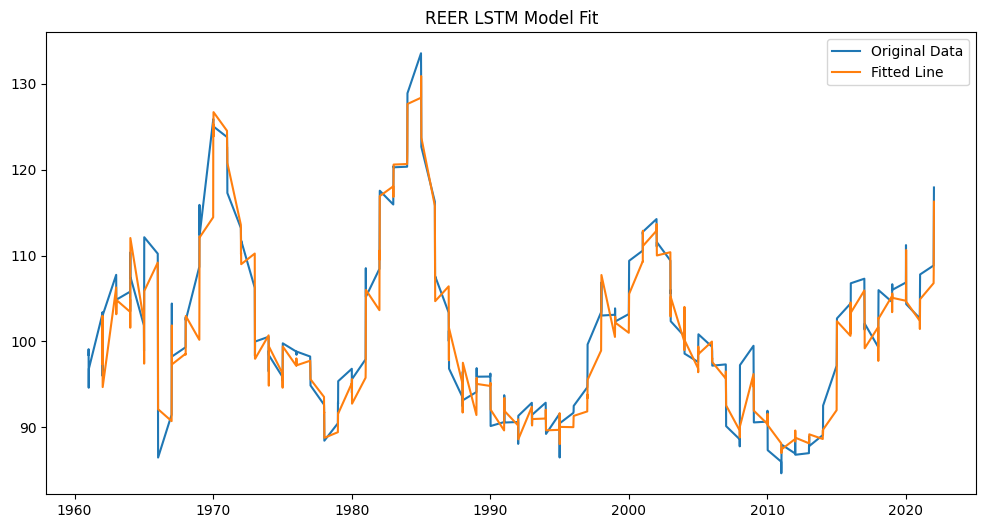

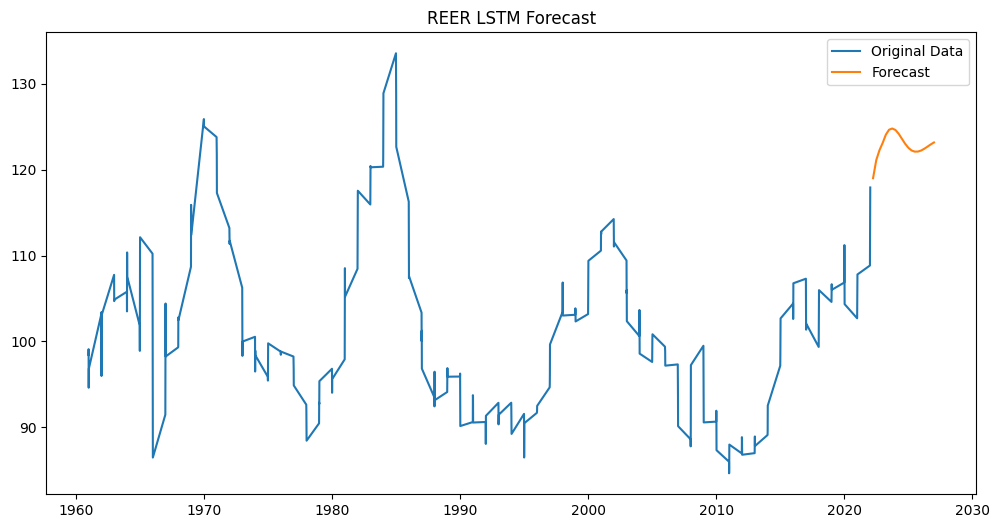

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.1601481188649117 0.9285648402253802 0.040028355349291764
Test:  2.7210264230982033 0.17827301694018427 0.09256134078942793
FITTED MAPE: 0.04529281410507742, RMSE: 0.7095881510912599, MAE: 0.2822633278832738


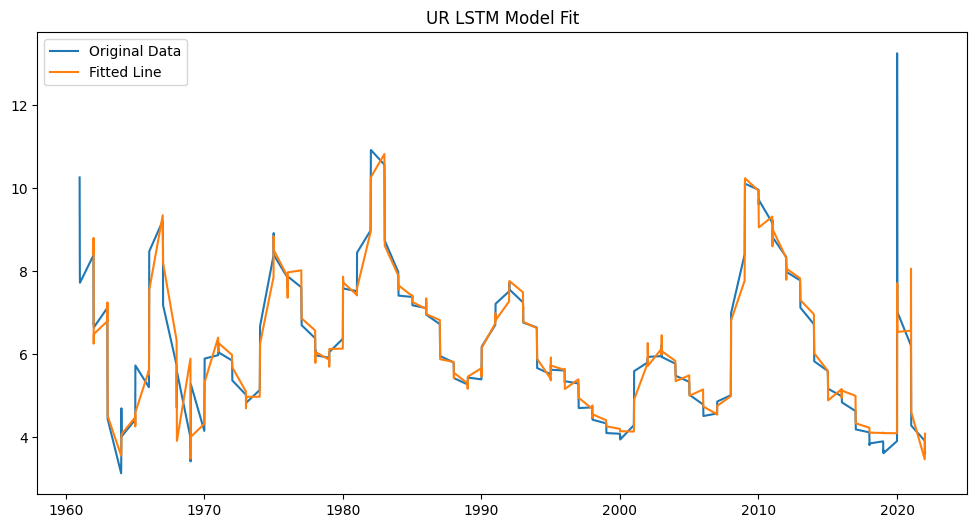

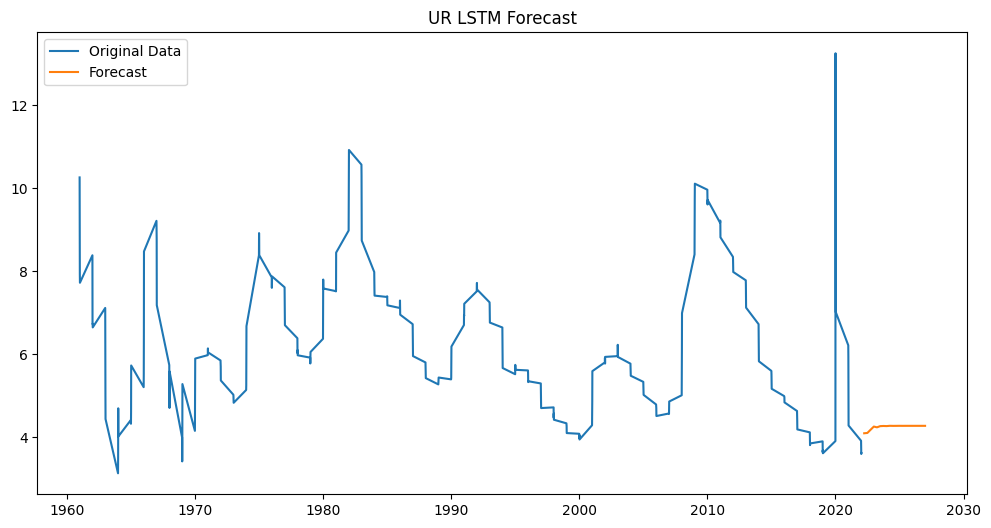

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.23169569302319717 0.6967951177141658 0.3455321552747146
Test:  4.004336044236875 0.18305031353668155 0.6600275332706822
FITTED MAPE: 0.6384464642646441, RMSE: 0.9103987654897392, MAE: 0.41050788630905033


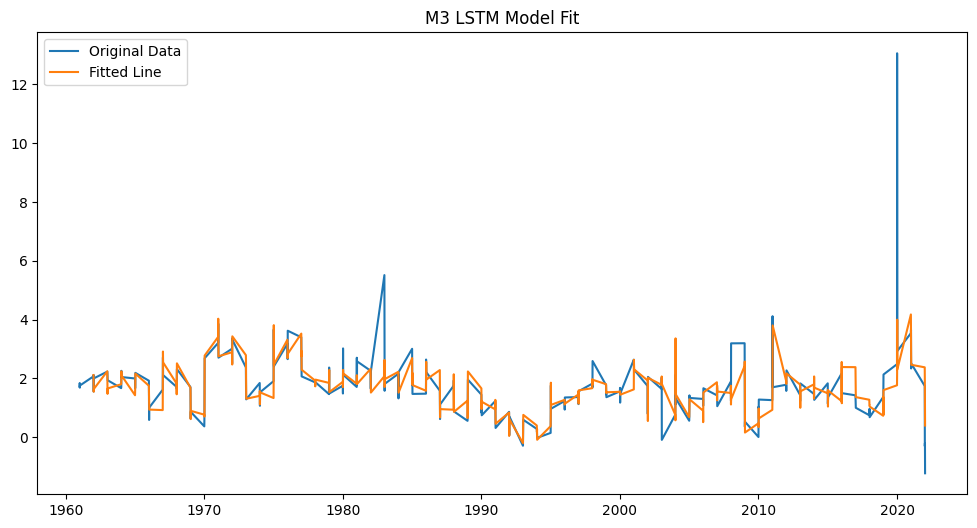

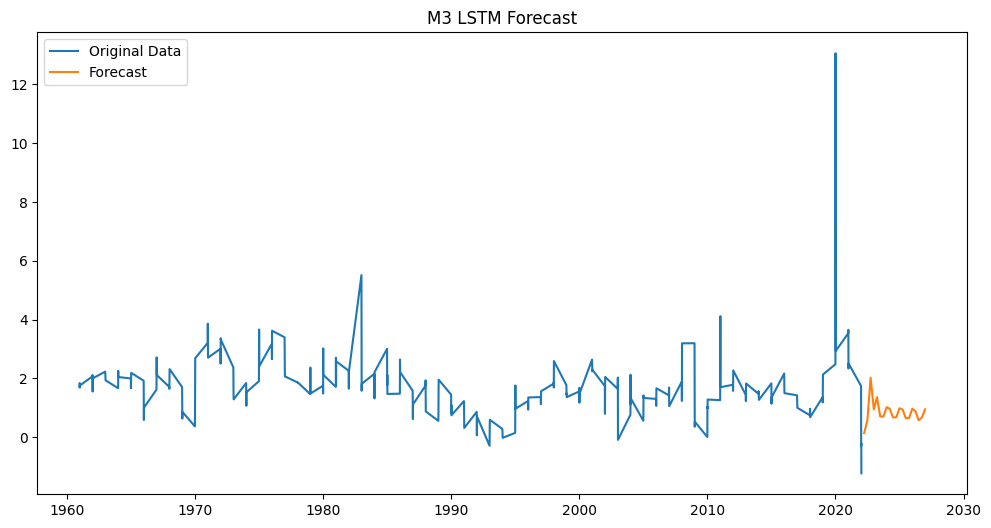

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.26276199154726515 0.7466894402781887 72049797494505.92
Test:  8.501123328131113 -0.40547855150820133 35.3717683623168
FITTED MAPE: 49903343346609.95, RMSE: 1.3728940510727428, MAE: 0.7354935403679959


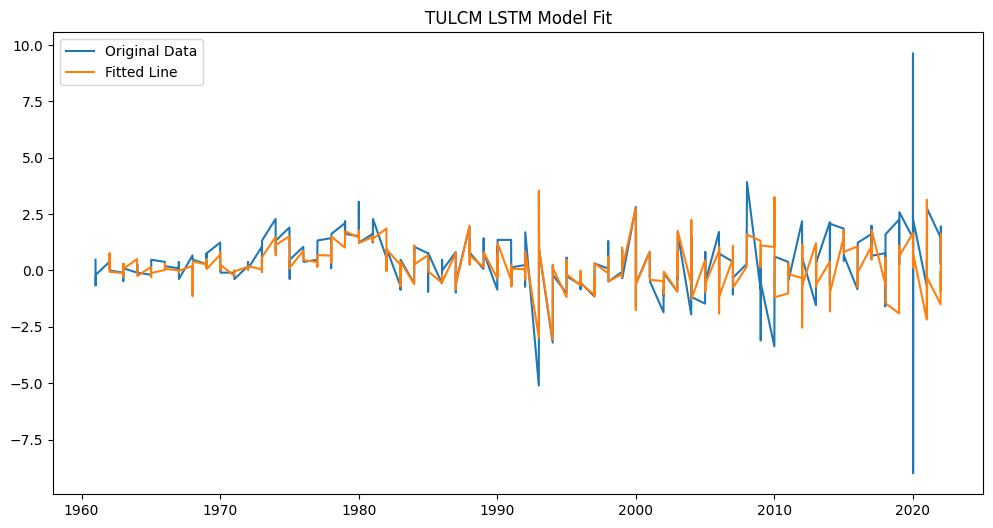

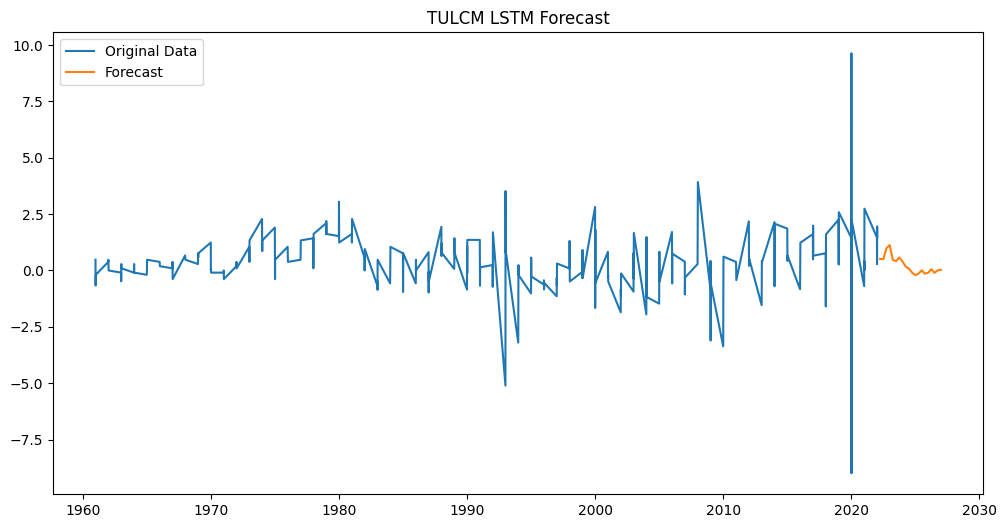

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.00955813881584241 0.8595012451609543 0.34530587180489497
Test:  0.5657921423797596 0.19952429243054803 3.839880505490204
FITTED MAPE: 0.9678613416119869, RMSE: 0.4182213749031011, MAE: 0.2098456343037678


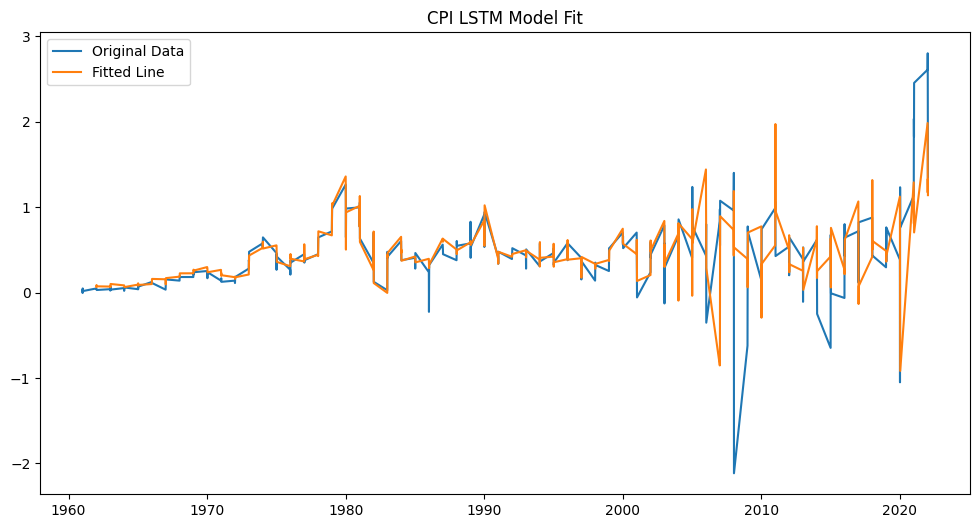

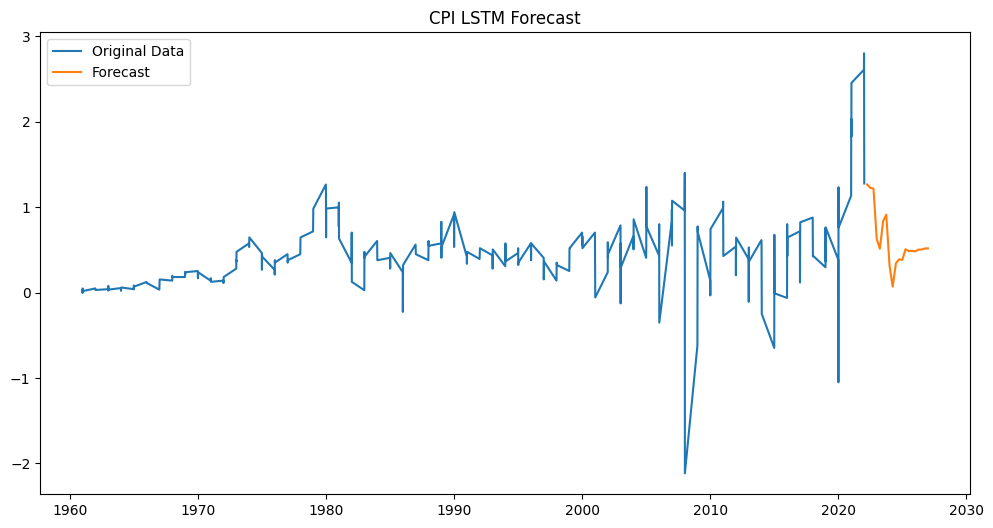

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  10.773327709787086 0.7014832271778537 0.5225921346064352
Test:  37.76498087280712 -0.5514901256033253 2.491121646197694
FITTED MAPE: 1.0174810970687573, RMSE: 4.876249275998809, MAE: 2.8287176584760387


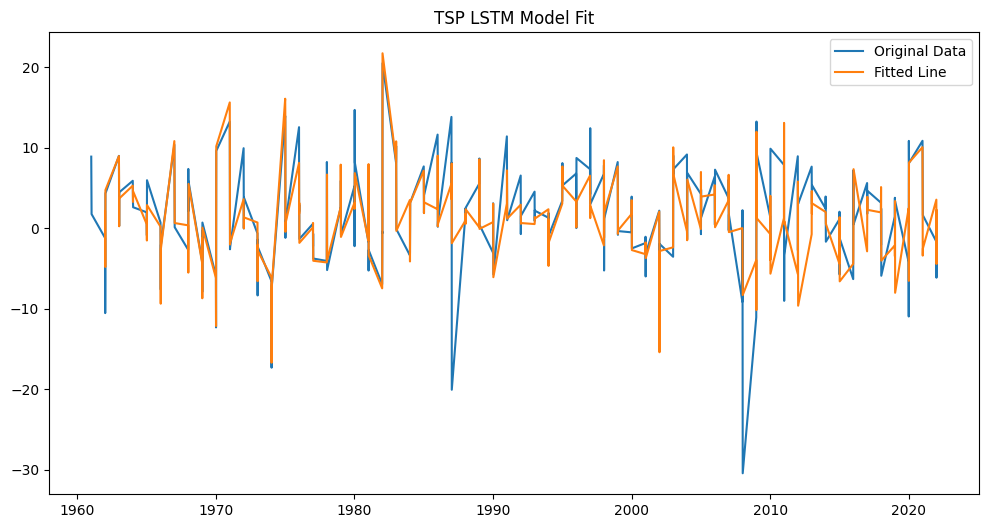

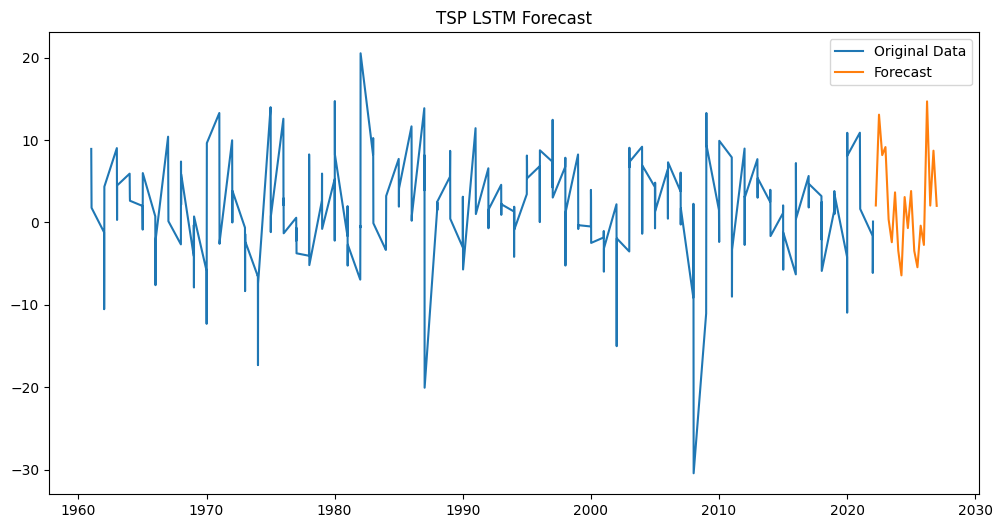

<ipython-input-56-b7160bff2a1d>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.5643502170571846 0.526296620213587 2.776880532230304
Test:  14.61699140099834 -1.2223473553617477 2.679966823695531
FITTED MAPE: 3.271659431194513, RMSE: 1.9551283765489003, MAE: 1.1779791099881949


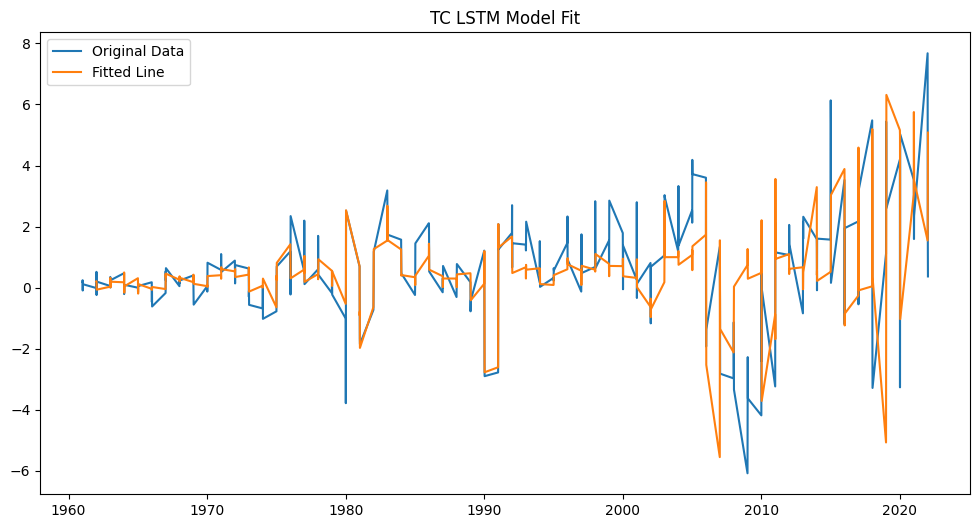

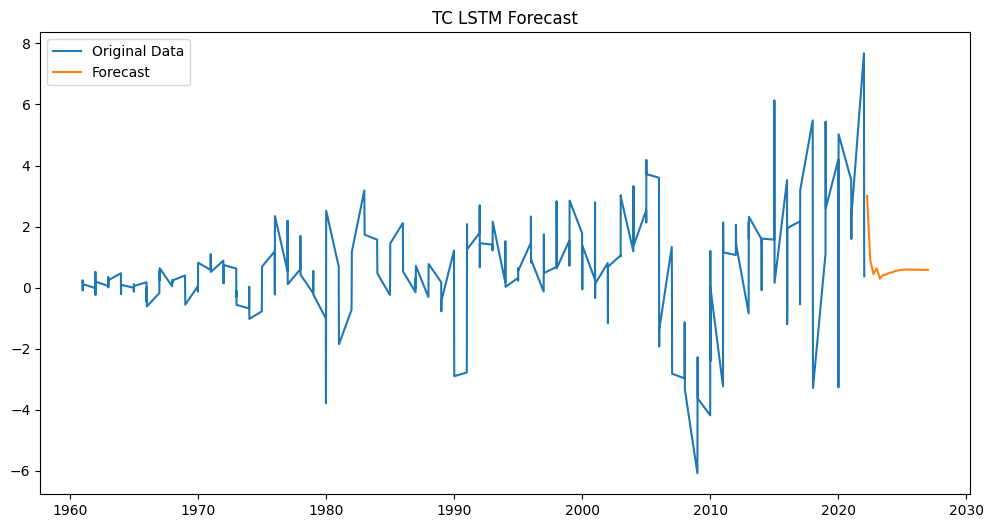

In [ ]:
epochs = 1000
batch_size = 32
cols = {
    "REER":'reer',
    "TSP":"tsp",
    "TULCM":'dtulcm',
    "UR":"ur",
    # "GDP":"dgdp",
    # "PPI":"dppi",
    "CPI":"dcpi",
    "TC":"dtc",
    "TMP":"dtmp",
    "M3":"m3"

}
metrics = {
    "VAR": [],
    "MAPE": [],
    "RMSE": [],
    "MAE": []
}
for feature in model_arch.keys():

    col = feature

    # Step 1: Convert time series data to train, valid and test
    train_data, valid_data, test_data = split_timeseries(df)
    look_back = 4
    # Step 1.2: Convert data into x and y suitable for time series lstm model
    look_back = model_arch[feature]['lookback']
    train_X, train_Y = create_dataset(train_data, col, look_back)
    valid_X, valid_Y = create_dataset(valid_data, col, look_back)
    test_X, test_Y = create_dataset(test_data, col, look_back)
    # print(train_X.shape)
    # Define the name for the current model
    model_name = feature + 'LSTM' + "Model" + '.h5'

    # Define the Keras model
    def create_model():
        model = Sequential(model_arch[feature]['layers'])
        model.compile(loss='mean_absolute_error', optimizer=model_arch[feature]['optimizer'])
        return model

    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min')

    # Wrap the Keras model inside a KerasRegressor
    lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))

    # Define the pipeline steps
    steps = [('scaler', model_arch[feature]["scaler"]), ('regressor', lstm_regressor)]

    # Create the pipeline
    pipeline = Pipeline(steps)

    # Train the model
    pipeline.fit(train_X, train_Y)

    joblib.dump(pipeline, f"{feature}_lstm_pipeline.joblib")
    # scores = pipeline.score(test_x, test_y, scoring=[mean_squared_error, r2_score, mean_absolute_percentage_error])

    # print(train_X.shape)
    train_pred = pipeline.predict(train_X)

    # print(train_Y.shape, train_pred.shape)

    trainmse = mean_squared_error(train_Y, train_pred)
    trainr2 = r2_score(train_Y, train_pred)
    trainmape = mean_absolute_percentage_error(train_Y, train_pred)
    print("Train: ", trainmse, trainr2, trainmape)

    # Evaluate the model on the test set
    test_pred = pipeline.predict(test_X)

    # print(test_Y.shape, test_pred.shape)

    mse = mean_squared_error(test_Y, test_pred)
    r2 = r2_score(test_Y, test_pred)
    mape = mean_absolute_percentage_error(test_Y, test_pred)
    print("Test: ", mse, r2, mape)
    X, Y = create_dataset(df, col, look_back)
    # print(X.shape)

    y_pred = pipeline.predict(X)

    rmse = mean_squared_error(Y, y_pred, squared = False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)
    mae = mean_absolute_error(Y, y_pred)
    print(f"FITTED MAPE: {mape}, RMSE: {rmse}, MAE: {mae}")
    metrics["VAR"].append(feature)
    metrics["MAPE"].append(mape)
    metrics["RMSE"].append(rmse)
    metrics["MAE"].append(mae)

    # Step 5: Plot original data vs the fitted line (containing predictions on both train and test data)
    plt.figure(figsize=(12,6))
    plt.plot(df[col], label='Original Data')
    plt.plot(df.index[look_back:], y_pred, label='Fitted Line')
    plt.title(f'{feature} LSTM Model Fit')
    plt.legend()
    plt.show()

    # Step 6: Forecast 20 quarters into the future
    n_periods = 20 # Number of quarters to forecast for
    future_forecasts = []

    # select the last `look_back` quarters of data for this feature
    last_quarters = df[col].values[-look_back-1:].reshape(-1, 1)
    # print(last_quarters)
    # initialize a list to store the forecasted values for this feature
    forecast = []

    # forecast values for the next `n_periods` quarters
    for j in range(n_periods):

        input_data = last_quarters[-look_back:]
        # print("id", input_data.reshape(-1, 1), input_data.reshape(-1, 1).shape, j)

        # predict the next value using the trained LSTM model
        yhat = pipeline.predict(input_data.reshape(1, look_back))

        # append the forecasted value to the list
        forecast.append(yhat)

        # update the `last_quarters` list with the new forecasted value
        last_quarters = np.append(last_quarters, yhat).reshape(-1, 1)
        # print("lq", last_quarters.shape, j)

    # append the forecasted values for this feature to the `future_forecasts` list
    future_forecasts = forecast

    # Step 7: Save forecasted values in a dataframe
    forecasted_df = pd.DataFrame({'Forecast': future_forecasts},
                                  index=pd.date_range(start=test_data.index[-1],
                                                     periods=20, freq='Q'))
    forecasted_df.index.name = 'Quarter'
    forecasted_df.columns.name = feature
    forecasted_df.to_csv(f'{feature}_forecast.csv')

    # Step 8: Visualize the original data with the forecasted values
    plt.figure(figsize=(12,6))
    plt.plot(df[col], label='Original Data')
    plt.plot(forecasted_df.index, forecasted_df.Forecast, label='Forecast')
    plt.title(f'{feature} LSTM Forecast')
    plt.legend()
    plt.show()


# Plotting ARIMA forecasts

In [ ]:
arima_exo_forecasts = pd.read_csv("Exo_Forecasts_ARIMA.csv", index_col = "DATE", parse_dates=['DATE'])

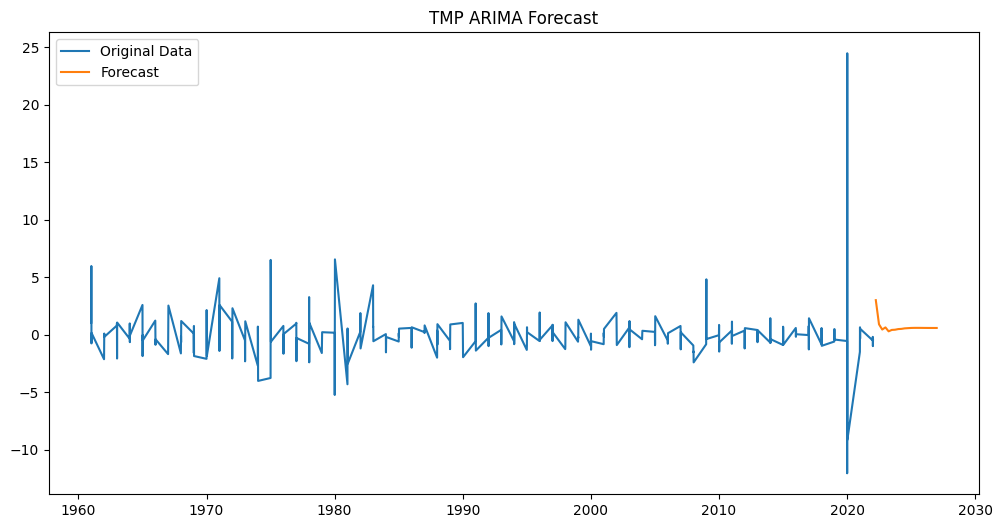

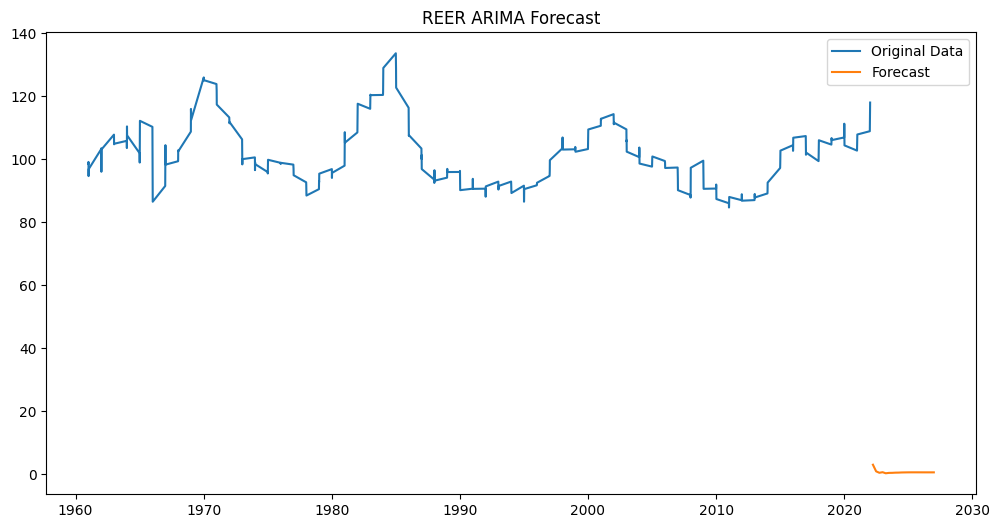

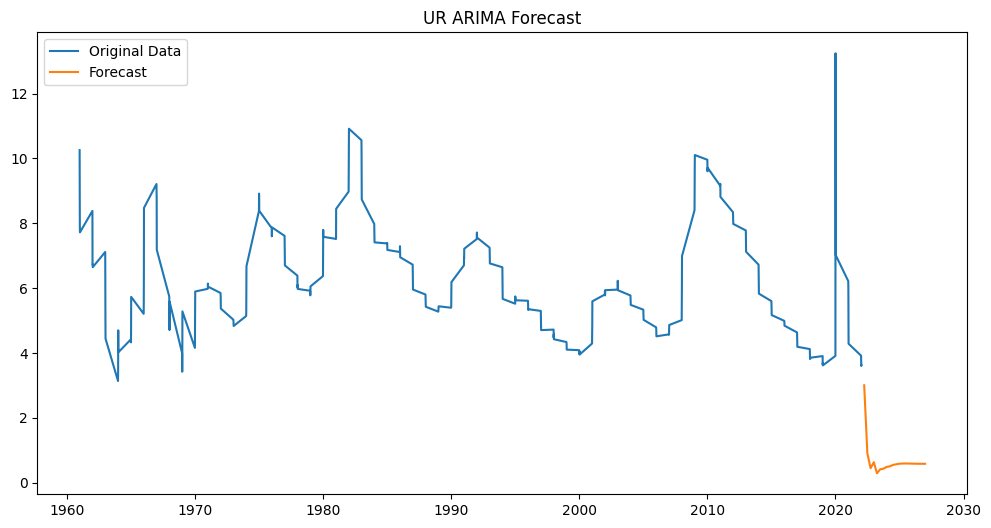

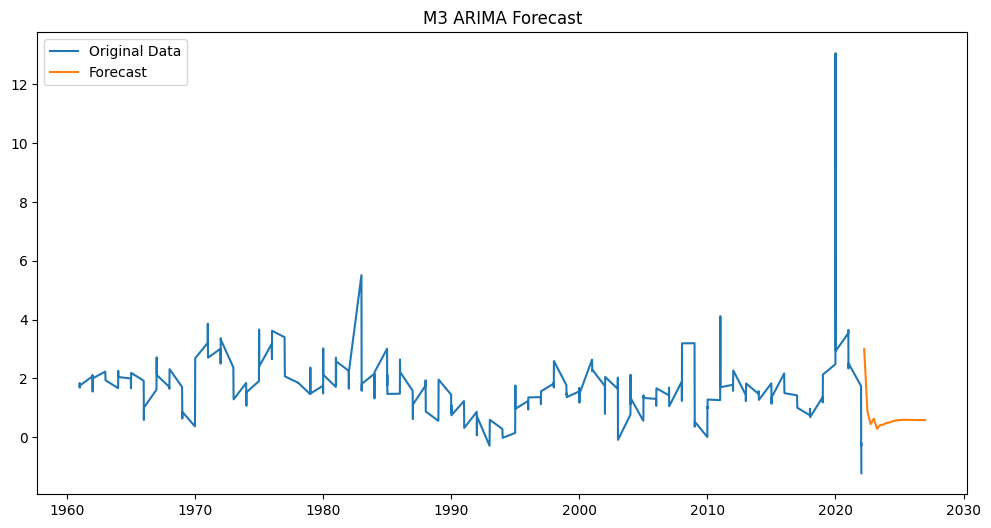

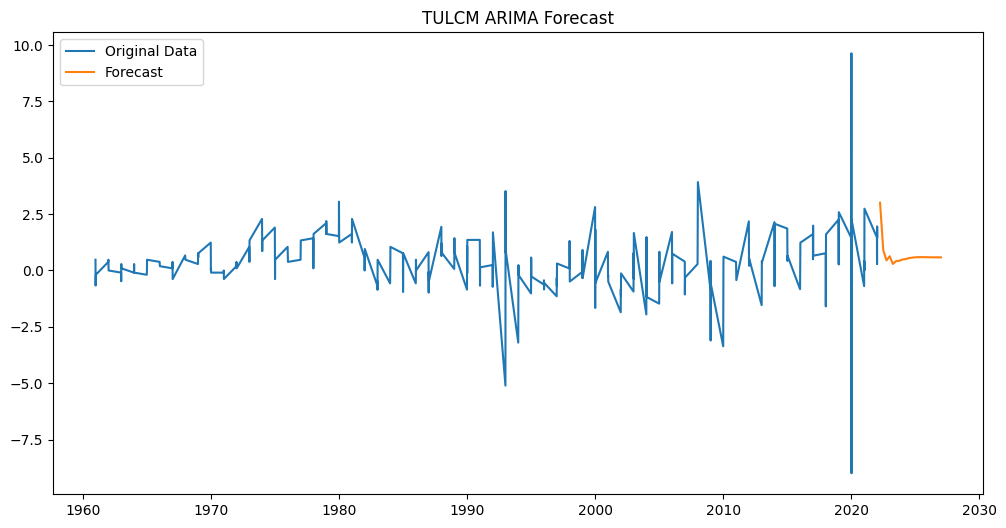

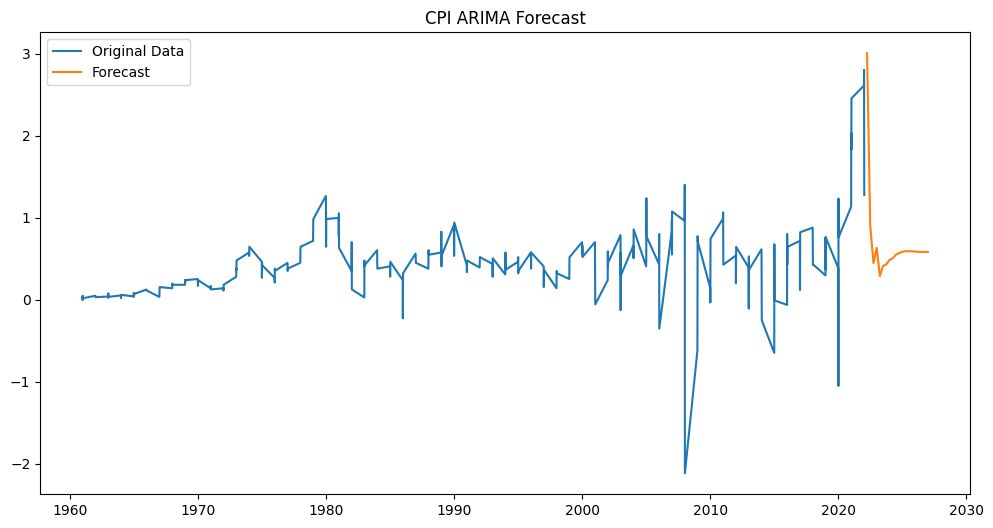

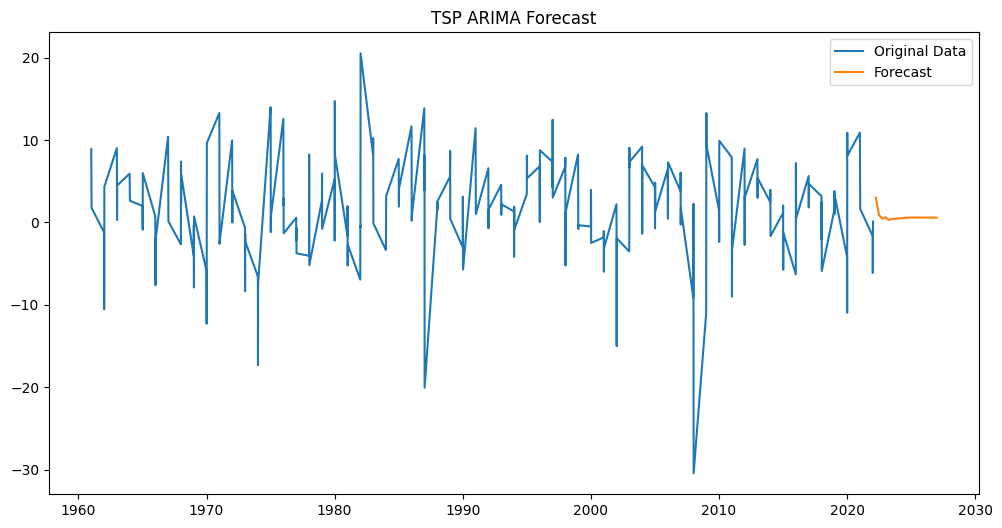

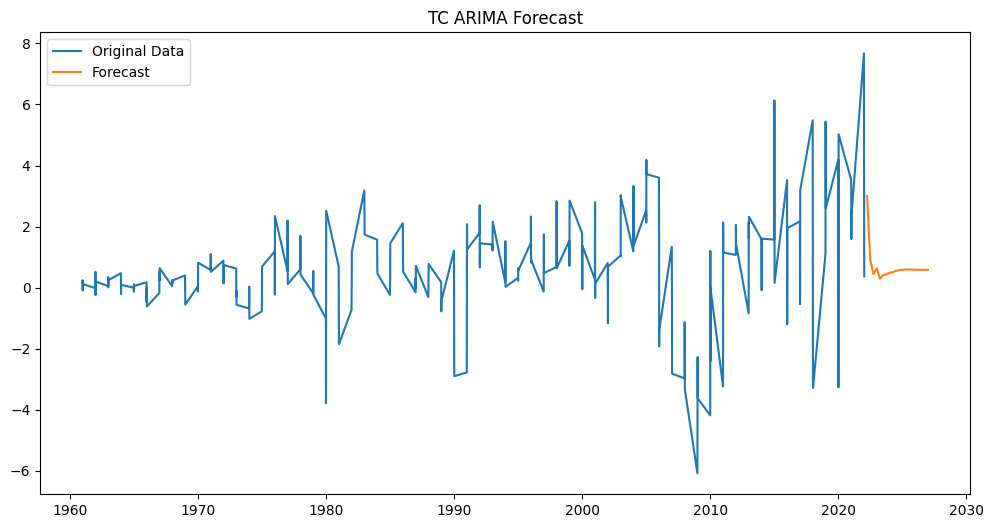

In [ ]:
for col in arima_exo_forecasts.columns:
    plt.figure(figsize=(12,6))
    plt.plot(df[col], label='Original Data')
    plt.plot(forecasted_df.index, forecasted_df.Forecast, label='Forecast')
    plt.title(f'{col} ARIMA Forecast')
    plt.legend()
    plt.show()

# Comparing Metrics of ARIMA and LSTM models

In [ ]:
metrics_exo_lstm = pd.DataFrame(metrics, columns = ["MAPE", "RMSE", "MAE"])

In [ ]:
metrics_exo_arima = pd.read_csv("Metrics_exo_arima.csv", index_col = "VARIABLE")
metrics_exo_lstm = metrics_exo_lstm.set_index(metrics_exo_arima.index)

In [ ]:
metrics_exo_lstm, metrics_exo_arima

(                  MAPE      RMSE       MAE
 VARIABLE                                  
 TMP       1.668574e+00  1.969925  0.750420
 REER      2.010323e-02  2.779076  2.054792
 UR        4.529281e-02  0.709588  0.282263
 M3        6.384465e-01  0.910399  0.410508
 TULCM     4.990334e+13  1.372894  0.735494
 CPI       9.678613e-01  0.418221  0.209846
 TSP       1.017481e+00  4.876249  2.828718
 TC        3.271659e+00  1.955128  1.177979,
                 MAPE      RMSE       MAE
 VARIABLE                                
 TMP       219.225900  1.931715  1.108898
 REER        2.103376  2.850707  2.140080
 UR          6.485002  0.811907  0.409876
 M3        126.833700  0.811907  0.525742
 TULCM       0.748915  1.303397  0.833416
 CPI        82.936220  0.363896  0.205943
 TSP       192.412500  5.773896  4.204706
 TC        778.000800  1.480434  0.664454)

In [ ]:
metrics_exo_lstm.to_csv("metrics_exo_lstm.csv")

In [ ]:
metrics_exo_lstm["MAE"] < metrics_exo_arima["MAE"]

VARIABLE
TMP       True
REER      True
UR        True
M3        True
TULCM     True
CPI      False
TSP       True
TC       False
Name: MAE, dtype: bool

## Combining the best forecasts of exo variables

In [ ]:
exo_arima_forecasts = pd.read_csv("Exo_Forecasts_ARIMA.csv", parse_dates = ["DATE"], index_col = "DATE")

In [ ]:
exo_arima_forecasts.head()

,TMP,REER,UR,M3,TULCM,CPI,TSP,TC
DATE,,,,,,,,
2023-01-01,0.924107,116.982050,3.898966,0.112845,0.786821,1.490249,1.613391,0.898653
2023-01-04,2.050833,116.493890,4.142460,0.555167,0.794712,1.507981,1.669495,1.174772
2023-01-07,-4.161672,116.052134,4.372775,0.880676,0.757100,1.690209,1.669495,1.318064
2023-01-10,1.650688,115.138238,4.578227,1.102990,0.753291,1.739662,1.669495,1.392426
2024-01-01,0.348871,114.070378,4.779224,1.276456,0.726928,1.699110,1.669495,1.431016


In [ ]:
tmp_lstm_forecast = pd.read_csv("TMP_forecast.csv").set_index(exo_arima_forecasts.index)
tmp_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

reer_lstm_forecast = pd.read_csv("REER_forecast.csv").set_index(exo_arima_forecasts.index)
reer_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

ur_lstm_forecast = pd.read_csv("UR_forecast.csv").set_index(exo_arima_forecasts.index)
ur_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

m3_lstm_forecast = pd.read_csv("M3_forecast.csv").set_index(exo_arima_forecasts.index)
m3_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

tulcm_lstm_forecast = pd.read_csv("TULCM_forecast.csv").set_index(exo_arima_forecasts.index)
tulcm_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

cpi_lstm_forecast = pd.read_csv("CPI_forecast.csv").set_index(exo_arima_forecasts.index)
cpi_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

tsp_lstm_forecast = pd.read_csv("TSP_forecast.csv").set_index(exo_arima_forecasts.index)
tsp_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

tc_lstm_forecast = pd.read_csv("TC_forecast.csv").set_index(exo_arima_forecasts.index)
tc_lstm_forecast.drop("Quarter", axis = 1, inplace = True)

In [ ]:
best_forecasts = pd.DataFrame({
  "TMP": tmp_lstm_forecast["Forecast"],
  "REER": reer_lstm_forecast["Forecast"],
  "UR": ur_lstm_forecast["Forecast"],
  "M3": m3_lstm_forecast["Forecast"],
  "TULCM": tulcm_lstm_forecast["Forecast"],
  "CPI": exo_arima_forecasts["CPI"],
  "TSP": tsp_lstm_forecast["Forecast"],
  "TC": exo_arima_forecasts["TC"]
}, index = exo_arima_forecasts.index)
best_forecasts.to_csv("EXO_BEST_FORECASTS.csv")

In [ ]:
import os

dir='/content/'

for root, dirs, files in os.walk(dir):
  for name in files:
    if not name.endswith((".csv")):
      os.remove(os.path.join(root, name))

# Forecasting/predicting GDP growth rate

## LSTM

In [ ]:
lookback = 4
model_arch = {
    "GDP" : {
        "layers" : [LSTM(128, input_shape=(lookback, 1), return_sequences=True), LSTM(32), Dense(16), Dense(1)],
        "optimizer": RMSprop(0.001),
        "scaler": StandardScaler(),
        "lookback": 4
    }
}

<ipython-input-93-4fe2687cc24f>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))


Train:  0.03626763924115525 0.9728948004129518 1.2260563574561725
Test:  11.33518704284127 -0.16051375231432696 1.987713136674004
FITTED MAPE: 1.4523731189372695, RMSE: 1.3591786480226762, MAE: 0.49143709859152934


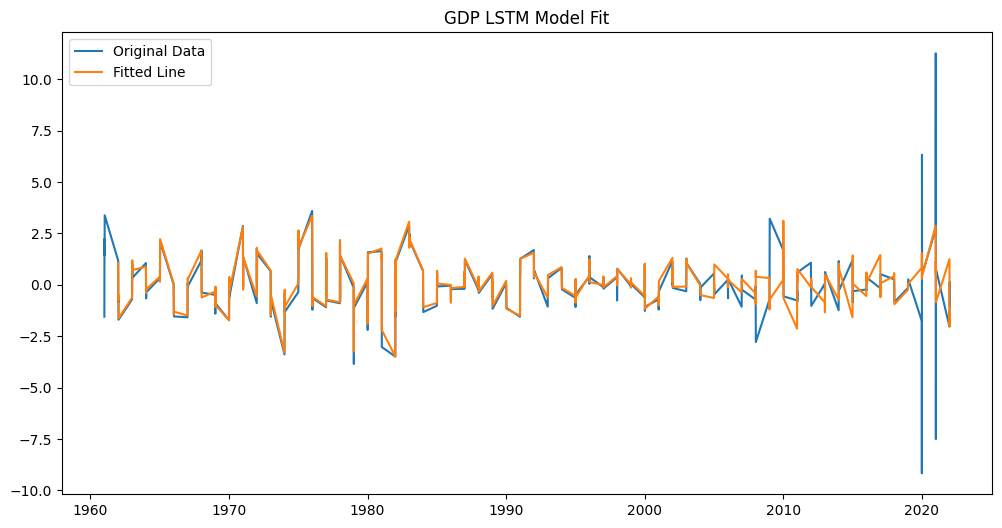

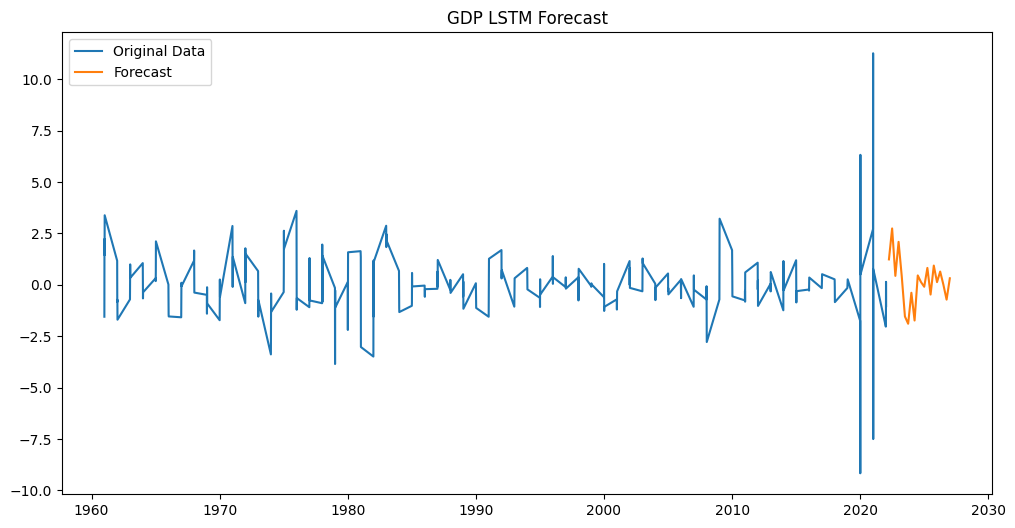

In [ ]:
epochs = 1000
batch_size = 32
cols = {
    # "REER":'reer',
    # "TSP":"tsp",
    # "TULCM":'dtulcm',
    # "UR":"ur",
    "GDP":"dgdp",
    # "PPI":"dppi",
    # "CPI":"dcpi",
    # "TC":"dtc",
    # "TMP":"dtmp",
    # "M3":"m3"

}
metrics = {
    "VAR": [],
    "MAPE": [],
    "RMSE": [],
    "MAE": []
}
for feature in model_arch.keys():

    col = feature

    # Step 1: Convert time series data to train, valid and test
    train_data, valid_data, test_data = split_timeseries(df)
    look_back = 4
    # Step 1.2: Convert data into x and y suitable for time series lstm model
    look_back = model_arch[feature]['lookback']
    train_X, train_Y = create_dataset(train_data, col, look_back)
    valid_X, valid_Y = create_dataset(valid_data, col, look_back)
    test_X, test_Y = create_dataset(test_data, col, look_back)
    # print(train_X.shape)
    # Define the name for the current model
    model_name = feature + 'LSTM' + "Model" + '.h5'

    # Define the Keras model
    def create_model():
        model = Sequential(model_arch[feature]['layers'])
        model.compile(loss='mean_absolute_error', optimizer=model_arch[feature]['optimizer'])
        return model

    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min')

    # Wrap the Keras model inside a KerasRegressor
    lstm_regressor = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [checkpoint],  validation_data=(valid_X, valid_Y))

    # Define the pipeline steps
    steps = [('scaler', model_arch[feature]["scaler"]), ('regressor', lstm_regressor)]

    # Create the pipeline
    pipeline = Pipeline(steps)

    # Train the model
    pipeline.fit(train_X, train_Y)

    joblib.dump(pipeline, f"{feature}_lstm_pipeline.joblib")
    # scores = pipeline.score(test_x, test_y, scoring=[mean_squared_error, r2_score, mean_absolute_percentage_error])

    # print(train_X.shape)
    train_pred = pipeline.predict(train_X)

    # print(train_Y.shape, train_pred.shape)

    trainmse = mean_squared_error(train_Y, train_pred)
    trainr2 = r2_score(train_Y, train_pred)
    trainmape = mean_absolute_percentage_error(train_Y, train_pred)
    print("Train: ", trainmse, trainr2, trainmape)

    # Evaluate the model on the test set
    test_pred = pipeline.predict(test_X)

    # print(test_Y.shape, test_pred.shape)

    mse = mean_squared_error(test_Y, test_pred)
    r2 = r2_score(test_Y, test_pred)
    mape = mean_absolute_percentage_error(test_Y, test_pred)
    print("Test: ", mse, r2, mape)
    X, Y = create_dataset(df, col, look_back)
    # print(X.shape)

    y_pred = pipeline.predict(X)

    rmse = mean_squared_error(Y, y_pred, squared = False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)
    mae = mean_absolute_error(Y, y_pred)
    print(f"FITTED MAPE: {mape}, RMSE: {rmse}, MAE: {mae}")
    metrics["VAR"].append(feature)
    metrics["MAPE"].append(mape)
    metrics["RMSE"].append(rmse)
    metrics["MAE"].append(mae)

    # Step 5: Plot original data vs the fitted line (containing predictions on both train and test data)
    plt.figure(figsize=(12,6))
    plt.plot(df[col], label='Original Data')
    plt.plot(df.index[look_back:], y_pred, label='Fitted Line')
    plt.title(f'{feature} LSTM Model Fit')
    plt.legend()
    plt.show()

    # Step 6: Forecast 20 quarters into the future
    n_periods = 20 # Number of quarters to forecast for
    future_forecasts = []

    # select the last `look_back` quarters of data for this feature
    last_quarters = df[col].values[-look_back-1:].reshape(-1, 1)
    # print(last_quarters)
    # initialize a list to store the forecasted values for this feature
    forecast = []

    # forecast values for the next `n_periods` quarters
    for j in range(n_periods):

        input_data = last_quarters[-look_back:]
        # print("id", input_data.reshape(-1, 1), input_data.reshape(-1, 1).shape, j)

        # predict the next value using the trained LSTM model
        yhat = pipeline.predict(input_data.reshape(1, look_back))

        # append the forecasted value to the list
        forecast.append(yhat)

        # update the `last_quarters` list with the new forecasted value
        last_quarters = np.append(last_quarters, yhat).reshape(-1, 1)
        # print("lq", last_quarters.shape, j)

    # append the forecasted values for this feature to the `future_forecasts` list
    future_forecasts = forecast

    # Step 7: Save forecasted values in a dataframe
    forecasted_df = pd.DataFrame({'Forecast': future_forecasts},
                                  index=pd.date_range(start=test_data.index[-1],
                                                     periods=20, freq='Q'))
    forecasted_df.index.name = 'Quarter'
    forecasted_df.columns.name = feature
    forecasted_df.to_csv(f'{feature}_forecast.csv')

    # Step 8: Visualize the original data with the forecasted values
    plt.figure(figsize=(12,6))
    plt.plot(df[col], label='Original Data')
    plt.plot(forecasted_df.index, forecasted_df.Forecast, label='Forecast')
    plt.title(f'{feature} LSTM Forecast')
    plt.legend()
    plt.show()


In [ ]:
X = data.drop(['GDP','PPI'], axis = 1)
y = data['GDP']

x_pred = pd.read_csv("EXO_BEST_FORECASTS.csv")
x_pred.index = x_pred["DATE"]
x_pred.drop("DATE", axis = 1, inplace = True)

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.to_numpy().reshape((-1,1)))

In [ ]:
x_pred = sc_X.transform(x_pred)

## MLP

In [ ]:
mlp_regr = MLPRegressor(random_state=10, max_iter=100000).fit(X, y[:,0])

In [ ]:
y_pred = mlp_regr.predict(X)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
print(
    f"""MAPE: {mean_absolute_percentage_error(y, y_pred=y_pred)}
RMSE: {mean_squared_error(y, y_pred=y_pred, squared = False)}
MAE: {mean_absolute_error(y, y_pred=y_pred)}""")

MAPE: 2.1569610822407648
RMSE: 0.521903545940016
MAE: 0.32077376441101185


In [ ]:
y_pred = mlp_regr.predict(x_pred)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
y_pred

array([[-1.78801032],
       [-3.90622956],
       [-2.30588222],
       [-5.80891556],
       [-3.62789671],
       [-2.56061847],
       [-5.02005897],
       [-2.79830926],
       [-0.79616948],
       [-2.96163947],
       [-3.07857049],
       [-4.69412913],
       [-3.57877328],
       [-2.30931242],
       [-1.91884033],
       [-1.97512132],
       [-4.54443507],
       [-3.31639356],
       [-5.18924924],
       [-3.50556587]])

In [ ]:
pd.DataFrame(y_pred[:,0]).to_csv("GDPFORECAST_MLP.csv")

## SVR

In [ ]:
svr_regr = SVR(kernel = 'rbf')
svr_regr.fit(X, y[:,0])

SVR()

In [ ]:
y_pred = svr_regr.predict(X)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
print(
    f"""MAPE: {mean_absolute_percentage_error(y, y_pred=y_pred)}
RMSE: {mean_squared_error(y, y_pred=y_pred, squared = False)}
MAE: {mean_absolute_error(y, y_pred=y_pred)}""")

MAPE: 3.1328697869933917
RMSE: 0.7723324775871311
MAE: 0.42078791303770346


In [ ]:
y_pred = svr_regr.predict(x_pred)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
y_pred

array([[-0.90640295],
       [-0.42995436],
       [ 0.07297664],
       [-0.4406132 ],
       [-0.63220542],
       [-0.84408499],
       [-0.82850491],
       [-0.81028584],
       [-0.62773839],
       [-0.70387161],
       [-0.97290169],
       [-0.82285139],
       [-0.98877962],
       [-0.93002968],
       [-0.84492293],
       [-0.80141937],
       [-0.31530078],
       [-0.904054  ],
       [-0.70247139],
       [-0.7713881 ]])

In [ ]:
pd.DataFrame(y_pred[:,0]).to_csv("GDPFORECAST_SVR.csv")

## DT

In [ ]:
# create an instance of the decision tree regressor
dt = DecisionTreeRegressor(random_state=100)

# fit the model on the training data
dt.fit(X, y)

DecisionTreeRegressor(random_state=100)

In [ ]:
y_pred = dt.predict(X)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
print(
    f"""MAPE: {mean_absolute_percentage_error(y, y_pred=y_pred)}
RMSE: {mean_squared_error(y, y_pred=y_pred, squared = False)}
MAE: {mean_absolute_error(y, y_pred=y_pred)}""")

MAPE: 0.5771896635614505
RMSE: 0.5770773953456243
MAE: 0.35081773186886933


In [ ]:
y_pred = dt.predict(x_pred)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
y_pred

array([[-0.58928507],
       [-0.03667885],
       [-0.89113267],
       [-0.70607763],
       [-0.58928507],
       [-0.58928507],
       [-0.70607763],
       [-0.58928507],
       [-0.89113267],
       [-0.89113267],
       [-0.58928507],
       [-0.58928507],
       [-0.58928507],
       [-0.58928507],
       [-0.89113267],
       [-0.89113267],
       [-0.03667885],
       [-0.58928507],
       [-0.58928507],
       [-0.58928507]])

In [ ]:
pd.DataFrame(y_pred[:,0]).to_csv("GDPFORECAST_DT.csv")

## RF

In [ ]:
# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=0)

# fit the regressor with x and y data
rf.fit(X, y.ravel())

RandomForestRegressor(random_state=0)

In [ ]:
y_pred = rf.predict(X)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
print(
    f"""MAPE: {mean_absolute_percentage_error(y, y_pred=y_pred)}
RMSE: {mean_squared_error(y, y_pred=y_pred, squared = False)}
MAE: {mean_absolute_error(y, y_pred=y_pred)}""")

MAPE: 1.4729340475545056
RMSE: 0.24706025845980303
MAE: 0.17269043617593963


In [ ]:
y_pred = rf.predict(x_pred)
y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred))
y_pred

array([[-0.28365558],
       [ 0.39218376],
       [-0.16284958],
       [-0.28371763],
       [-0.69213613],
       [-0.67003003],
       [-0.6724868 ],
       [-0.73452047],
       [-0.35643296],
       [-0.79213198],
       [-0.95284277],
       [-0.79595437],
       [-0.97249061],
       [-0.82568966],
       [-0.78216784],
       [-0.77796316],
       [-0.35207631],
       [-0.97677073],
       [-0.73696132],
       [-0.99136872]])

In [ ]:
pd.DataFrame(y_pred[:,0]).to_csv("GDPFORECAST_RF.csv")

## Consider only the best forecasts and visualize it

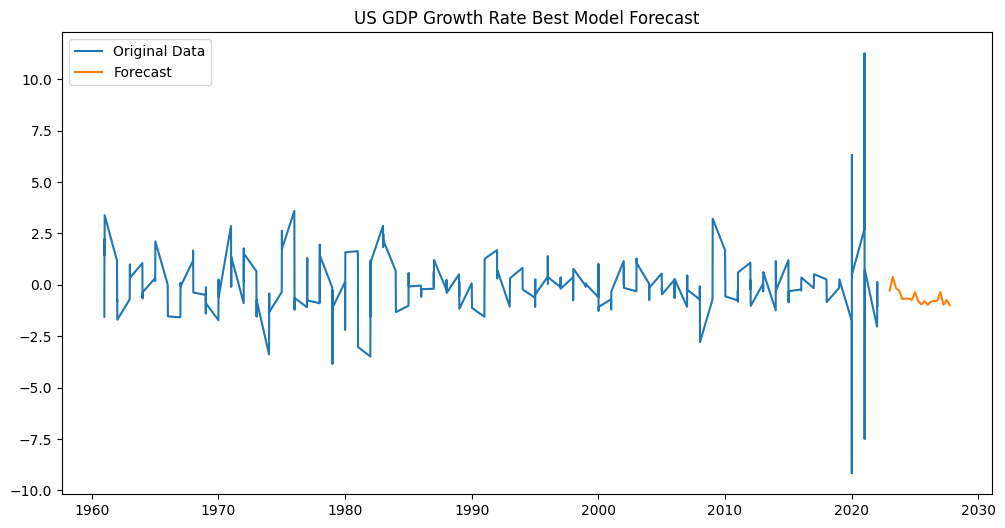

In [ ]:
us_f = pd.read_csv("GDPFORECAST_RF.csv")

plt.figure(figsize=(12,6))
plt.plot(df[col], label='Original Data')
plt.plot(forecasted_df.index, us_f["0"], label='Forecast')
plt.title(f'US GDP Growth Rate Best Model Forecast')
plt.legend()
plt.show()

Random Forest has the least MAE

# Fit Regression Line

In [ ]:
INDIA = pd.read_csv("INDIA_GDPGrowthRate.csv")
# Convert the date column to a Pandas datetime format
INDIA['DATE'] = pd.to_datetime(INDIA['DATE'])

# Set the date column as the DataFrame index
INDIA.set_index('DATE', inplace=True)

In [ ]:
US = pd.read_csv("US Finalized.csv")

# Convert the date column to a Pandas datetime format
US['DATE'] = pd.to_datetime(US['DATE'], format = "%d/%m/%Y")

# Set the date column as the DataFrame index
US.set_index('DATE', inplace=True)

start_date = '2012-04-01'
# end_date = '2022-04-01'
US = US.loc[start_date:]

In [ ]:
US = US["GDP"]

In [ ]:
reg1 = LinearRegression().fit(US.to_numpy().reshape((-1,1)), INDIA["INDGDPRQPSMEI"])

In [ ]:
reg1.intercept_

1.8311293864303133

In [ ]:
reg1.coef_

array([1.856346])

In [ ]:
reg1.score(US.to_numpy().reshape((-1,1)), INDIA["INDGDPRQPSMEI"])

0.7284649434520303

$R^2 = 0.72846$

$y = 1.8311 + 1.8563X$

$y = β_{0} + β_{1}x$ + ϵ

## Visualize

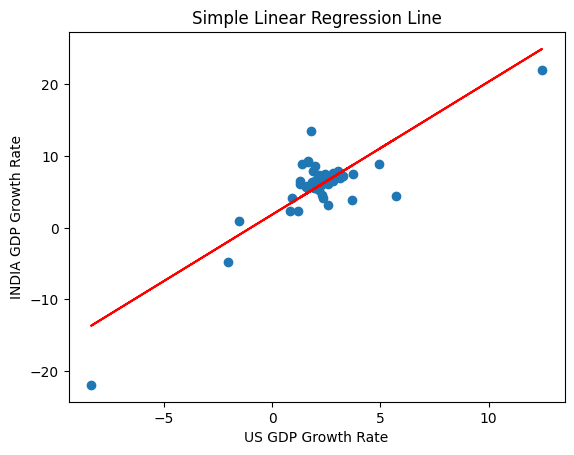

In [ ]:
import numpy as np

# Generate some sample data
x = np.arange(-8,12)

# Plot the data points and regression line
plt.scatter(US.to_numpy().reshape((-1,1)),INDIA["INDGDPRQPSMEI"])
plt.plot(US.to_numpy().reshape((-1,1)), reg1.predict(US.to_numpy().reshape((-1,1))), color='red')
plt.title("Simple Linear Regression Line")
plt.xlabel("US GDP Growth Rate")
plt.ylabel("INDIA GDP Growth Rate")
plt.show()

# Predicting Indian GDP Growth Rate

In [ ]:
us_f = pd.read_csv("GDPFORECAST_RF.csv")
# Convert the date column to a Pandas datetime format
# us_f['DATE'] = pd.to_datetime(us_f['DATE'])


# Set the date column as the DataFrame index
p = reg1.predict(us_f["0"].to_numpy().reshape((-1,1)))

In [ ]:
forecasted_df = pd.DataFrame({'GDP Growth Rate (India)': p},
                              index=pd.date_range(start=US.index[-1],
                                                  periods=20, freq='Q'))

forecasted_df.to_csv(f'India_Future_GDP_Growth.csv')


## Visualizing and saving forecasts

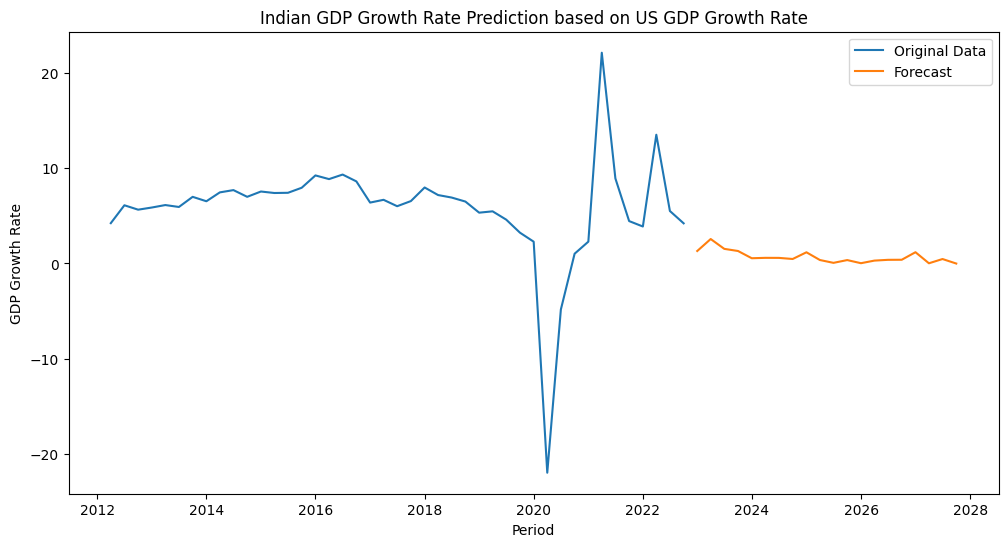

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(INDIA["INDGDPRQPSMEI"], label='Original Data')
plt.plot(forecasted_df.index, forecasted_df["GDP Growth Rate (India)"], label='Forecast')
plt.title(f'Indian GDP Growth Rate Prediction based on US GDP Growth Rate')
plt.xlabel("Period")
plt.ylabel("GDP Growth Rate")
plt.legend()
plt.show()

In [ ]:
forecasted_df

,GDP Growth Rate (India)
2022-12-31,1.304566
2023-03-31,2.559158
2023-06-30,1.528824
2023-09-30,1.304451
2023-12-31,0.546285
2024-03-31,0.587322
2024-06-30,0.582761
2024-09-30,0.467605
2024-12-31,1.169466
2025-03-31,0.360658
